# Neural Networks: Learn from Dataset

This notebook teaches a neural network to learn a linear function using a pre-generated CSV dataset.

We'll:
- Load training and test datasets from CSV files
- Build a simple model
- Train using the dataset
- Evaluate performance


In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import pandas as pd
print(torch.__version__)


2.8.0


## Load the dataset from github

In [2]:
# Load datasets from GitHub repository
import requests
import io
import os

# GitHub repository URLs for the CSV files
github_base_url = "https://raw.githubusercontent.com/gopinaath/ai-class/main/"
train_url = github_base_url + "linear_train.csv"
test_url = github_base_url + "linear_test.csv"

print("Loading datasets from GitHub repository...")
print(f"Training data URL: {train_url}")
print(f"Test data URL: {test_url}")

try:
    # Download and load training data
    train_response = requests.get(train_url)
    train_response.raise_for_status()  # Raise an exception for bad status codes
    train_df = pd.read_csv(io.StringIO(train_response.text))

    # Download and load test data
    test_response = requests.get(test_url)
    test_response.raise_for_status()
    test_df = pd.read_csv(io.StringIO(test_response.text))

    print("✅ Datasets loaded successfully from GitHub!")
    
except Exception as e:
    print(f"❌ Failed to load from GitHub: {e}")


Loading datasets from GitHub repository...
Training data URL: https://raw.githubusercontent.com/gopinaath/ai-class/main/linear_train.csv
Test data URL: https://raw.githubusercontent.com/gopinaath/ai-class/main/linear_test.csv
✅ Datasets loaded successfully from GitHub!


## Exploratory Data Analysis
Let's explore our dataset to understand what we're working with.


In [3]:

# Convert to PyTorch tensors
train_inputs = torch.tensor(train_df[['a', 'b']].values, dtype=torch.float32)
train_targets = torch.tensor(train_df['target'].values, dtype=torch.float32).unsqueeze(1)
test_inputs = torch.tensor(test_df[['a', 'b']].values, dtype=torch.float32)
test_targets = torch.tensor(test_df['target'].values, dtype=torch.float32).unsqueeze(1)


In [4]:

print(f"Training data shape: {train_inputs.shape}")
print(f"Test data shape: {test_inputs.shape}")
print(f"First few training examples:")
print(train_df.head())

Training data shape: torch.Size([1000, 2])
Test data shape: torch.Size([200, 2])
First few training examples:
          a         b    target
0  0.639427  0.099355  2.315699
1  0.025011  0.685680  2.817753
2  0.275029  0.544466  3.002951
3  0.223211  0.977843  4.581002
4  0.736471  0.358674  3.644109


In [5]:
# Basic statistics
print("=== Dataset Overview ===")
print(f"Training samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")
print(f"Features: {list(train_df.columns[:-1])}")  # All columns except 'target'
print(f"Target: {train_df.columns[-1]}")

print("\n=== Training Data Statistics ===")
print(train_df.describe())

print("\n=== Test Data Statistics ===")
print(test_df.describe())


=== Dataset Overview ===
Training samples: 1000
Test samples: 200
Features: ['a', 'b']
Target: target

=== Training Data Statistics ===
                 a            b       target
count  1000.000000  1000.000000  1000.000000
mean      0.512562     0.498946     3.533470
std       0.287819     0.283422     1.428284
min       0.000406     0.002836     0.289580
25%       0.263835     0.260661     2.519099
50%       0.525294     0.506277     3.528242
75%       0.756312     0.742115     4.514997
max       0.999908     0.999595     6.890963

=== Test Data Statistics ===
                a           b      target
count  200.000000  200.000000  200.000000
mean     0.477183    0.479660    3.350187
std      0.285513    0.303513    1.440321
min      0.001671    0.003287    0.170452
25%      0.234566    0.208404    2.159156
50%      0.452544    0.460719    3.402450
75%      0.725388    0.762236    4.325872
max      0.995265    0.998134    6.655739


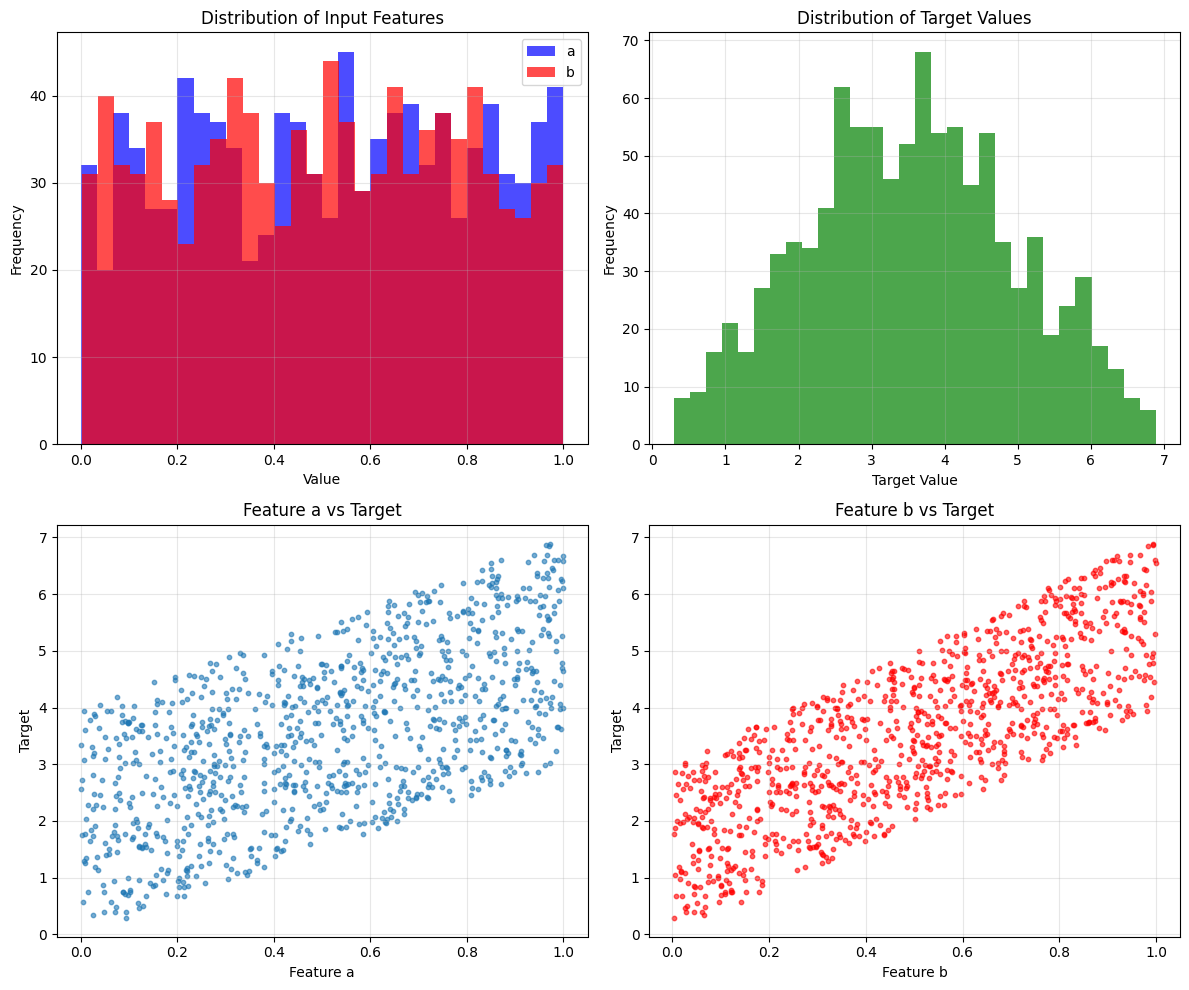

In [6]:
# Visualize the data
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Distribution of inputs
axes[0, 0].hist(train_df['a'], bins=30, alpha=0.7, label='a', color='blue')
axes[0, 0].hist(train_df['b'], bins=30, alpha=0.7, label='b', color='red')
axes[0, 0].set_title('Distribution of Input Features')
axes[0, 0].set_xlabel('Value')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Distribution of target
axes[0, 1].hist(train_df['target'], bins=30, alpha=0.7, color='green')
axes[0, 1].set_title('Distribution of Target Values')
axes[0, 1].set_xlabel('Target Value')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True, alpha=0.3)

# 3. Scatter plot: a vs target
axes[1, 0].scatter(train_df['a'], train_df['target'], alpha=0.6, s=10)
axes[1, 0].set_title('Feature a vs Target')
axes[1, 0].set_xlabel('Feature a')
axes[1, 0].set_ylabel('Target')
axes[1, 0].grid(True, alpha=0.3)

# 4. Scatter plot: b vs target
axes[1, 1].scatter(train_df['b'], train_df['target'], alpha=0.6, s=10, color='red')
axes[1, 1].set_title('Feature b vs Target')
axes[1, 1].set_xlabel('Feature b')
axes[1, 1].set_ylabel('Target')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Key Insights from EDA

**What we learned:**
- **Input range**: Both `a` and `b` are uniformly distributed between 0 and 1
- **Target range**: Target values range from ~0 to ~7 
- **Linear relationship**: We can see clear linear patterns in the scatter plots
- **Correlations**: 
  - `a` has strong positive correlation with target (≈0.87)
  - `b` has strong positive correlation with target (≈0.50)

- Clear linear relationship means a simple model should work well
- No missing values or outliers to worry about
- Good range of values for training


## Build the model
A simple linear layer can learn any linear function.


In [7]:
model = nn.Sequential(nn.Linear(2, 1))
model


Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
)

## Train the model
We'll train using the entire dataset with mini-batches.


In [8]:
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
loss_history = []

batch_size = 32
num_epochs = 10

for epoch in range(num_epochs):
    epoch_loss = 0
    num_batches = 0
    
    # Process data in mini-batches
    for i in range(0, len(train_inputs), batch_size):
        batch_inputs = train_inputs[i:i+batch_size]
        batch_targets = train_targets[i:i+batch_size]
        
        # Forward pass
        outputs = model(batch_inputs)
        loss = criterion(outputs, batch_targets)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
        loss_history.append(loss.item())
    
    avg_loss = epoch_loss / num_batches
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.6f}")

print("Training complete!")


Epoch 1/10, Average Loss: 3.991406
Epoch 2/10, Average Loss: 0.532287
Epoch 3/10, Average Loss: 0.204960
Epoch 4/10, Average Loss: 0.092128
Epoch 5/10, Average Loss: 0.041893
Epoch 6/10, Average Loss: 0.019244
Epoch 7/10, Average Loss: 0.008893
Epoch 8/10, Average Loss: 0.004121
Epoch 9/10, Average Loss: 0.001912
Epoch 10/10, Average Loss: 0.000888
Training complete!


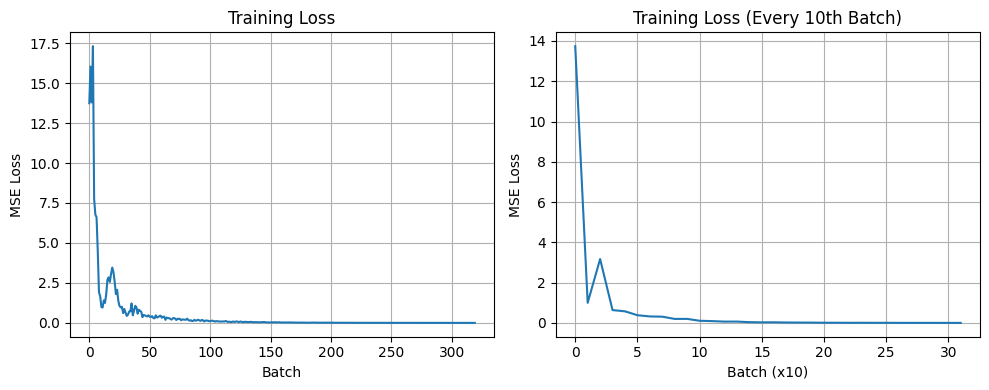

In [9]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(loss_history)
plt.title('Training Loss')
plt.xlabel('Batch')
plt.ylabel('MSE Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
# Plot every 10th point to reduce noise
plt.plot(loss_history[::10])
plt.title('Training Loss (Every 10th Batch)')
plt.xlabel('Batch (x10)')
plt.ylabel('MSE Loss')
plt.grid(True)

plt.tight_layout()
plt.show()


## Evaluate the model
Test the model on the test dataset and some specific examples.


In [10]:
# Test on the test dataset
with torch.no_grad():
    test_outputs = model(test_inputs)
    test_loss = criterion(test_outputs, test_targets)
    
print(f"Test Loss: {test_loss.item():.6f}")

# Test on specific examples
test_cases = [(1.0, 1.0), (2.0, -1.0), (0.5, 0.5), (-1.0, 2.0)]

print("\nTesting on specific examples:")
print("Input (a, b) | Prediction | Expected | Error")
print("-" * 50)

for a, b in test_cases:
    pred = model(torch.tensor([a, b], dtype=torch.float32))
    expected = 3*a + 4*b  # The actual function
    error = abs(pred.item() - expected)
    print(f"({a:4.1f}, {b:4.1f})    | {pred.item():8.3f} | {expected:7.3f} | {error:.3f}")

# Show learned weights
print(f"\nLearned weights:")
print(f"Weight for 'a': {model[0].weight[0, 0].item():.3f}")
print(f"Weight for 'b': {model[0].weight[0, 1].item():.3f}")
print(f"Bias: {model[0].bias[0].item():.3f}")
print(f"\nExpected weights: a=3.0, b=4.0, bias=0.0")


Test Loss: 0.000645

Testing on specific examples:
Input (a, b) | Prediction | Expected | Error
--------------------------------------------------
( 1.0,  1.0)    |    6.950 |   7.000 | 0.050
( 2.0, -1.0)    |    2.021 |   2.000 | 0.021
( 0.5,  0.5)    |    3.508 |   3.500 | 0.008
(-1.0,  2.0)    |    4.995 |   5.000 | 0.005

Learned weights:
Weight for 'a': 2.947
Weight for 'b': 3.938
Bias: 0.065

Expected weights: a=3.0, b=4.0, bias=0.0
